In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer, silhouette_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.compose import TransformedTargetRegressor

from category_encoders import TargetEncoder
import lightgbm as lgb

<font color='skyblue'> 
Here we will do some rather simple feature engineering to see if combining features leads to higher correlation with the target feature
</font>

In [2]:
X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_val = pd.read_csv("X_val_tran.csv")
y_val = pd.read_csv("y_val_tran.csv")
X_test = pd.read_csv("X_test_tran.csv")
y_test = pd.read_csv("y_test_tran.csv")

X_trainDF = pd.read_csv("X_train_DF.csv")
y_trainDF = pd.read_csv("y_train_DF.csv")
X_valDF = pd.read_csv("X_val_Df.csv")
y_valDF = pd.read_csv("y_val_DF.csv")
X_testDF = pd.read_csv("X_test_DF.csv")
y_testDF = pd.read_csv("y_test_DF.csv")

myColumns = X_train.columns
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

df = pd.read_csv("Customer-Churn-Records.csv")
df = df.drop(columns=['RowNumber','CustomerId'])
df = df.drop(columns=['Complain'])
df = df.rename(columns={'Card Type': 'CardType'})
df = df.rename(columns={'Point Earned': 'PointsEarned'})
df = df.rename(columns={'Geography': 'Country'})
df = df.rename(columns={'Satisfaction Score': 'SatisfactionScore'})
# save original columns
myColumns = df.columns

(8000, 15)
(8000, 1)
(1000, 15)
(1000, 1)


In [3]:
X_train.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,SatisfactionScore,CreditScoreOrd,AgeOrd,TaxBracket,BalanceOrd,PointsEarnedQuant,CardTypeOrd,SurnameOrd,CountryOrd,CountryHappy,GenderBinary
0,2,2,1,0,2,3,1,4,0,1.0,1.0,0.0,1,6.48,0
1,1,1,1,1,1,4,1,3,1,2.0,2.0,0.0,2,6.69,0
2,2,1,0,1,1,4,4,4,3,2.0,0.0,0.0,2,6.69,0
3,4,1,1,0,1,2,1,1,2,0.0,2.0,2.0,3,7.03,1
4,8,2,0,1,3,3,3,3,0,2.0,0.0,0.0,2,6.69,1


<font color='lightblue'> 
Here is the original correlation map (plus the countryHappy feature)
</font>

In [4]:
numeric_column_selector = make_column_selector(dtype_include=np.number)
num_cols = numeric_column_selector(X_train)
print(num_cols)

object_column_selector = make_column_selector(dtype_include='object')
object_cols = object_column_selector(X_train)
print(object_cols)

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'CreditScoreOrd', 'AgeOrd', 'TaxBracket', 'BalanceOrd', 'PointsEarnedQuant', 'CardTypeOrd', 'SurnameOrd', 'CountryOrd', 'CountryHappy', 'GenderBinary']
[]


In [5]:
X_train_full = pd.concat([X_train, y_train], axis=1)
num_cols.insert(0, 'Exited')
X_train_full_num = X_train_full[num_cols]

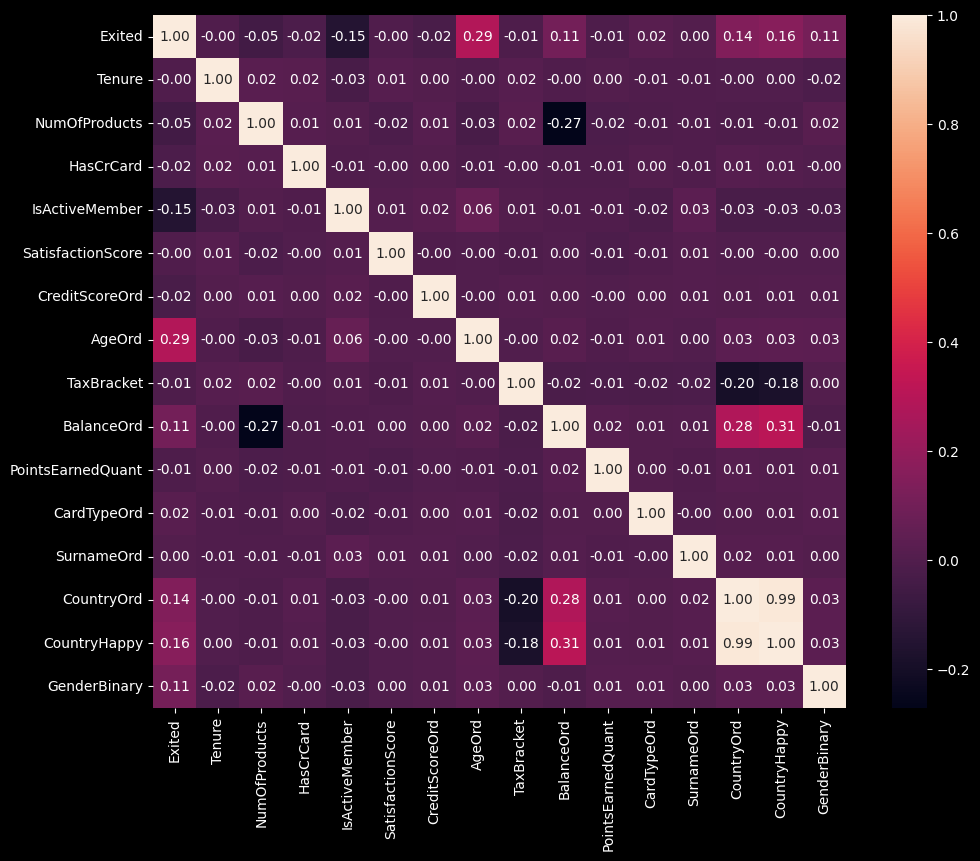

In [6]:
corrmat = X_train_full_num.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.xticks(rotation=90)

plt.show()

In [125]:
X_train.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,SatisfactionScore,CreditScoreOrd,AgeOrd,TaxBracket,BalanceOrd,PointsEarnedQuant,CardTypeOrd,SurnameOrd,CountryOrd,CountryHappy,GenderBinary
0,2,2,1,0,2,3,1,4,0,1.0,1.0,0.0,1,6.48,0
1,1,1,1,1,1,4,1,3,1,2.0,2.0,0.0,2,6.69,0
2,2,1,0,1,1,4,4,4,3,2.0,0.0,0.0,2,6.69,0
3,4,1,1,0,1,2,1,1,2,0.0,2.0,2.0,3,7.03,1
4,8,2,0,1,3,3,3,3,0,2.0,0.0,0.0,2,6.69,1


In [7]:
#
#* Exit correlation baseline
corr_matrix = X_train_full_num.corr()
corr_matrix["Exited"].sort_values(ascending=False)

Exited               1.000000
AgeOrd               0.289525
CountryHappy         0.160885
CountryOrd           0.144587
GenderBinary         0.106179
BalanceOrd           0.105665
CardTypeOrd          0.020144
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
TaxBracket          -0.010110
PointsEarnedQuant   -0.011745
HasCrCard           -0.016526
CreditScoreOrd      -0.024427
NumOfProducts       -0.048662
IsActiveMember      -0.147864
Name: Exited, dtype: float64

In [128]:
# X_train_comb
#* Create a new dataFrame that combines the transformed categorical features and the non-transformed continuous features 

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd','CardTypeOrd', 'CountryOrd']]
X_val_comb = X_val[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd','CardTypeOrd', 'CountryOrd']]
X_test_comb = X_test[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd','CardTypeOrd', 'CountryOrd']]

# here
X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])
X_val_comb = X_val_comb.join(X_valDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])
X_test_comb = X_test_comb.join(X_testDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)
# X_val_comb = pd.concat([X_val_comb, y_train],axis=1)
# X_test_comb = pd.concat([X_test_comb, y_train],axis=1)

X_train_comb.columns

Index(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd',
       'CountryOrd', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'PointsEarned', 'Exited'],
      dtype='object')

In [129]:
X_train_comb.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,SatisfactionScore,GenderBinary,SurnameOrd,CardTypeOrd,CountryOrd,CreditScore,Age,Balance,EstimatedSalary,PointsEarned,Exited
0,2,2,1,0,2,0,0.0,1.0,1,709,35,0.00,104982.39,422,0
1,1,1,1,1,1,0,0.0,2.0,2,744,29,43504.42,119327.75,607,0
2,2,1,0,1,1,0,0.0,0.0,2,773,64,145578.28,186172.85,630,0
3,4,1,1,0,1,1,2.0,2.0,3,646,29,105957.44,15470.91,345,0
4,8,2,0,1,3,1,0.0,0.0,2,675,57,0.00,95463.29,632,0


In [130]:
# X_train_comb Exited correlational baseline
corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

Exited               1.000000
Age                  0.280432
CountryOrd           0.144587
Balance              0.120726
GenderBinary         0.106179
CardTypeOrd          0.020144
EstimatedSalary      0.017851
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
IsActiveMember      -0.147864
Name: Exited, dtype: float64

<font color='skyblue'> 
Ok, so the simple method that will be used here is that we combine 2 features (by dividing them with each other to see if the new feature shows increased correlational value with Exited). 

This method does not work with the boolean features (dividing by 0) so i sipped them. I had planned to get back to this later and try something else but i did not end up having the time. 

We mainly look if we can increase the correlation score for low correlational features.

Each time we reset the X_train_comb so the dataFrame does not get flooded with features. Then we take the new features that shows promise and test them with different classification models.

</font>

In [131]:
#
#* CardTypeOrd

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.CardTypeOrd / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.CardTypeOrd / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.CardTypeOrd / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.CardTypeOrd / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.CardTypeOrd / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.CardTypeOrd / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.CardTypeOrd / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.CardTypeOrd / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.CardTypeOrd / X_train_comb.CreditScore
X_train_comb['test10'] = X_train_comb.CardTypeOrd / X_train_comb.NumOfProducts
X_train_comb['test11'] = X_train_comb.CardTypeOrd / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test10 seems promising lets keep it. CardType / NumOfProducts
#* Perhaps then there actually is a significant relationship between card type and purchases 

Exited               1.000000
Age                  0.280432
Balance              0.120726
GenderBinary         0.106179
test10               0.070721
test5                0.037784
test9                0.026724
test7                0.023856
test2                0.023256
test4                0.023243
test11               0.022368
test8                0.020403
CardTypeOrd          0.020144
test3                0.019147
EstimatedSalary      0.017851
test6                0.016399
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
test1               -0.075680
IsActiveMember      -0.147864
Name: Exited, dtype: float64

In [132]:
#
#* SurnnameOrd

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.SurnameOrd / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.SurnameOrd / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.SurnameOrd / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.SurnameOrd / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.SurnameOrd / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.SurnameOrd / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.SurnameOrd / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.SurnameOrd / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.SurnameOrd / X_train_comb.CreditScore
X_train_comb['test10'] = X_train_comb.SurnameOrd / X_train_comb.NumOfProducts
X_train_comb['test11'] = X_train_comb.SurnameOrd / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test11 seems promising. Lets try using this and dropping SurnameOrd


Exited               1.000000
Age                  0.280432
Balance              0.120726
GenderBinary         0.106179
CardTypeOrd          0.020144
EstimatedSalary      0.017851
test11               0.013738
test10               0.006891
test8                0.003263
test9                0.002003
SurnameOrd           0.001579
test7               -0.002762
test4               -0.002841
SatisfactionScore   -0.003726
Tenure              -0.004108
test1               -0.005862
test6               -0.006892
test3               -0.008845
PointsEarned        -0.012095
test2               -0.014602
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test5                     NaN
Name: Exited, dtype: float64

In [133]:
#
#* EstimatedSalary

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.EstimatedSalary / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.EstimatedSalary / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.EstimatedSalary / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.EstimatedSalary / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.EstimatedSalary / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.EstimatedSalary / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.EstimatedSalary / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.EstimatedSalary / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.EstimatedSalary / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.EstimatedSalary / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.EstimatedSalary / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test5 seems VERY promising lets keep it. EstimatedSalary / SurnameOrd

Exited               1.000000
Age                  0.280432
test5                0.231549
Balance              0.120726
GenderBinary         0.106179
tes10                0.082338
test3                0.035790
test9                0.033166
CardTypeOrd          0.020144
test7                0.017941
EstimatedSalary      0.017851
test2                0.017270
test8                0.013818
tes11                0.009606
test6                0.006592
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
test1               -0.096449
IsActiveMember      -0.147864
test4                     NaN
Name: Exited, dtype: float64

In [134]:
#
#* SatisfactionScore

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.SatisfactionScore / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.SatisfactionScore / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.SatisfactionScore / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.SatisfactionScore / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.SatisfactionScore / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.SatisfactionScore / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.SatisfactionScore / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.SatisfactionScore / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.SatisfactionScore / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.SatisfactionScore / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.SatisfactionScore / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test5 seems promising, but it is very similar to EstimatedSalary / SurnameOrd so lets not include it. 
#* test10 also seems promising, but it is very similar to SatisfactionScore / NumOfProducts

Exited               1.000000
Age                  0.280432
test5                0.178816
Balance              0.120726
GenderBinary         0.106179
tes10                0.072405
test4                0.023887
CardTypeOrd          0.020144
EstimatedSalary      0.017851
test7                0.007667
test9                0.004098
tes11                0.003316
SurnameOrd           0.001579
test3               -0.001827
SatisfactionScore   -0.003726
Tenure              -0.004108
test2               -0.007164
PointsEarned        -0.012095
HasCrCard           -0.016526
test8               -0.022851
CreditScore         -0.030191
NumOfProducts       -0.048662
test1               -0.137190
IsActiveMember      -0.147864
test6                     NaN
Name: Exited, dtype: float64

In [135]:
#
#* Tenure

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.Tenure / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.Tenure / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.Tenure / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.Tenure / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.Tenure / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.Tenure / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.Tenure / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.Tenure / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.Tenure / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.Tenure / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.Tenure / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test10 seems promising, but another test is very similar to EstimatedSalary / SurnameOrd
#* test7 seems promising since those features have not been tried yet

Exited               1.000000
Age                  0.280432
Balance              0.120726
GenderBinary         0.106179
tes10                0.066692
test4                0.026127
CardTypeOrd          0.020144
EstimatedSalary      0.017851
test2                0.007556
test7                0.005509
test9                0.003566
SurnameOrd           0.001579
test3                0.001017
test5                0.000679
test6                0.000581
SatisfactionScore   -0.003726
Tenure              -0.004108
test8               -0.007040
PointsEarned        -0.012095
HasCrCard           -0.016526
tes11               -0.017981
CreditScore         -0.030191
NumOfProducts       -0.048662
test1               -0.114932
IsActiveMember      -0.147864
Name: Exited, dtype: float64

In [136]:
#
#* PointsEarned

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.PointsEarned / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.PointsEarned / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.PointsEarned / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.PointsEarned / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.PointsEarned / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.PointsEarned / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.PointsEarned / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.PointsEarned / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.PointsEarned / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.PointsEarned / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.PointsEarned / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test5 seems promising, but another test is very similar to EstimatedSalary / SurnameOrd
#* test4 also seems promising, though it does not increase over IsActiveMember itself so we move on 

Exited               1.000000
Age                  0.280432
test5                0.169431
Balance              0.120726
GenderBinary         0.106179
tes10                0.086463
CardTypeOrd          0.020144
test4                0.019730
EstimatedSalary      0.017851
test2                0.005155
test9                0.003959
SurnameOrd           0.001579
test3               -0.003519
SatisfactionScore   -0.003726
test6               -0.003840
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
test8               -0.021071
tes11               -0.025110
CreditScore         -0.030191
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test1               -0.163127
test7                     NaN
Name: Exited, dtype: float64

In [138]:
#
#* CreditScore

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.CreditScore / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.CreditScore / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.CreditScore / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.CreditScore / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.CreditScore / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.CreditScore / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.CreditScore / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.CreditScore / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.CreditScore / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.CreditScore / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.CreditScore / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* Nothing stands out

Exited               1.000000
Age                  0.280432
test5                0.121731
Balance              0.120726
tes10                0.119672
GenderBinary         0.106179
test4                0.023529
CardTypeOrd          0.020144
EstimatedSalary      0.017851
test7                0.005705
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
test6               -0.008185
PointsEarned        -0.012095
test2               -0.014432
HasCrCard           -0.016526
test3               -0.027693
CreditScore         -0.030191
test8               -0.031362
tes11               -0.038211
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test1               -0.252285
test9                     NaN
Name: Exited, dtype: float64

In [139]:
#
#* NumOfProducts

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.NumOfProducts / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.NumOfProducts / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.NumOfProducts / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.NumOfProducts / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.NumOfProducts / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.NumOfProducts / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.NumOfProducts / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.NumOfProducts / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.NumOfProducts / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.NumOfProducts / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.NumOfProducts / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* Nothing stands out

Exited               1.000000
Age                  0.280432
test5                0.130568
Balance              0.120726
GenderBinary         0.106179
test2                0.049917
test4                0.021022
CardTypeOrd          0.020144
EstimatedSalary      0.017851
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
tes11               -0.008884
test7               -0.011971
PointsEarned        -0.012095
HasCrCard           -0.016526
test3               -0.024379
test6               -0.025474
test9               -0.029317
CreditScore         -0.030191
test8               -0.043350
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test1               -0.190817
tes10                     NaN
Name: Exited, dtype: float64

In [141]:
#
#* Age

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.Age / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.Age / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.Age / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.Age / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.Age / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.Age / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.Age / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.Age / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.Age / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.Age / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.Age / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test3 seems promising. Age / GenderBinary
#* test10 also seems promising. Perhaps it will be  better for the model since none of the features are booleans, though the increase is so small compared to Age by itself.

Exited               1.000000
test3                0.298647
tes10                0.280828
Age                  0.280432
test8                0.268612
test9                0.261650
test5                0.177153
tes11                0.168397
test2                0.165578
test7                0.153154
Balance              0.120726
GenderBinary         0.106179
test6                0.104478
test4                0.027433
CardTypeOrd          0.020144
EstimatedSalary      0.017851
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test1                     NaN
Name: Exited, dtype: float64

In [142]:
#
#* Balance

X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['test1'] = X_train_comb.Balance / X_train_comb.Age
X_train_comb['test2'] = X_train_comb.Balance / X_train_comb.Balance
X_train_comb['test3'] = X_train_comb.Balance / X_train_comb.GenderBinary
X_train_comb['test4'] = X_train_comb.Balance / X_train_comb.EstimatedSalary
X_train_comb['test5'] = X_train_comb.Balance / X_train_comb.SurnameOrd
X_train_comb['test6'] = X_train_comb.Balance / X_train_comb.SatisfactionScore
X_train_comb['test7'] = X_train_comb.Balance / X_train_comb.PointsEarned
X_train_comb['test8'] = X_train_comb.Balance / X_train_comb.HasCrCard
X_train_comb['test9'] = X_train_comb.Balance / X_train_comb.CreditScore
X_train_comb['tes10'] = X_train_comb.Balance / X_train_comb.NumOfProducts
X_train_comb['tes11'] = X_train_comb.Balance / X_train_comb.IsActiveMember

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

#* test3 seems promising. Balance / GenderBinary
#* test9 also seems promising. Balance / CreditScore

Exited               1.000000
Age                  0.280432
test5                0.204405
test3                0.130356
test9                0.124030
test8                0.122601
Balance              0.120726
tes10                0.112445
GenderBinary         0.106179
tes11                0.098731
test7                0.098042
test6                0.088910
test4                0.027769
CardTypeOrd          0.020144
test1                0.019678
EstimatedSalary      0.017851
SurnameOrd           0.001579
SatisfactionScore   -0.003726
Tenure              -0.004108
PointsEarned        -0.012095
HasCrCard           -0.016526
CreditScore         -0.030191
NumOfProducts       -0.048662
IsActiveMember      -0.147864
test2                     NaN
Name: Exited, dtype: float64

<font color='lightblue'> 
let us add the most promising new features to X_train_comb and see if they increase model training predictive power
</font>

In [144]:
X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_trainDF = pd.read_csv("X_train_DF.csv")

X_train_comb = X_train[['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd', 'CountryOrd']]

X_train_comb = X_train_comb.join(X_trainDF[['CreditScore', 'Age', 'Balance','EstimatedSalary', 'PointsEarned', ]])

X_train_comb = pd.concat([X_train_comb, y_train],axis=1)


X_train_comb['TenurePoints'] = X_train_comb.Tenure / X_train_comb.PointsEarned
X_train_comb['CardProducts'] = X_train_comb.CardTypeOrd / X_train_comb.NumOfProducts
X_train_comb['SatisfactionProducts'] = X_train_comb.SatisfactionScore / X_train_comb.NumOfProducts
X_train_comb['AgeProducts'] = X_train_comb.Age / X_train_comb.NumOfProducts
X_train_comb['BalanceCredit'] = X_train_comb.Balance / X_train_comb.CreditScore     

corr_matrix = X_train_comb.corr()
corr_matrix["Exited"].sort_values(ascending=False)

Exited                  1.000000
AgeProducts             0.280828
Age                     0.280432
CountryOrd              0.144587
BalanceCredit           0.124030
Balance                 0.120726
GenderBinary            0.106179
SatisfactionProducts    0.072405
CardProducts            0.070721
CardTypeOrd             0.020144
EstimatedSalary         0.017851
TenurePoints            0.005509
SurnameOrd              0.001579
SatisfactionScore      -0.003726
Tenure                 -0.004108
PointsEarned           -0.012095
HasCrCard              -0.016526
CreditScore            -0.030191
NumOfProducts          -0.048662
IsActiveMember         -0.147864
Name: Exited, dtype: float64

In [145]:
#* And the same for X_val and X_test

X_val_comb['TenurePoints'] = X_val_comb.Tenure / X_val_comb.PointsEarned
X_val_comb['CardProducts'] = X_val_comb.CardTypeOrd / X_val_comb.NumOfProducts
X_val_comb['SatisfactionProducts'] = X_val_comb.SatisfactionScore / X_val_comb.NumOfProducts
X_val_comb['AgeProducts'] = X_val_comb.Age / X_val_comb.NumOfProducts
X_val_comb['BalanceCredit'] = X_val_comb.Balance / X_val_comb.CreditScore

X_test_comb['TenurePoints'] = X_test_comb.Tenure / X_test_comb.PointsEarned
X_test_comb['CardProducts'] = X_test_comb.CardTypeOrd / X_test_comb.NumOfProducts
X_test_comb['SatisfactionProducts'] = X_test_comb.SatisfactionScore / X_test_comb.NumOfProducts
X_test_comb['AgeProducts'] = X_test_comb.Age / X_test_comb.NumOfProducts
X_test_comb['BalanceCredit'] = X_test_comb.Balance / X_test_comb.CreditScore 

<font color='lightblue'> 
Let us try to adding some clustering features and see if helps with prediction.
We will try these clustering methods:
 ¤ KMeans
 ¤ DBSCAN
 ¤ BayesianGaussianMixture

We will only try clustering with the continuous features and we will standard scale them beforehand
</font>

Best number of clusters: 2


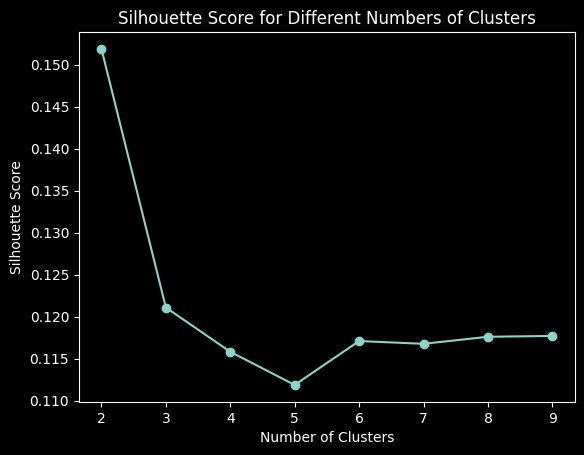

In [147]:
continuous_features = X_train_comb[['Tenure', 'NumOfProducts', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'PointsEarned']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(continuous_features)

silhouette_scores = []
best_score = -1
best_clusters = 0

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

    kmeans.fit(scaled_features)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_clusters = n_clusters

print("Best number of clusters:", best_clusters)

# Plotting the silhouette scores
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.show()

#* This does not look promising, but we will go with 2 (maybe try 3-4 later) since it works with our binary classification problem

kmeans = KMeans(n_clusters=best_clusters, random_state=43, n_init='auto')
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_
X_train_comb['ClusterKMeans'] = cluster_labels
# X_val_comb['ClusterKMeans'] = cluster_labels
# X_test_comb['ClusterKMeans'] = cluster_labels

In [148]:
#* Let us do the same for X_val and X_test

continuous_features_val = X_val_comb[['Tenure', 'NumOfProducts', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'PointsEarned']]

scaled_features_val = scaler.transform(continuous_features_val)

cluster_labels_val = kmeans.predict(scaled_features_val)
X_val_comb['ClusterKMeans'] = cluster_labels_val


continuous_features_test = X_test_comb[['Tenure', 'NumOfProducts', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'PointsEarned']]

scaled_features_test = scaler.transform(continuous_features_test)

cluster_labels_test = kmeans.predict(scaled_features_test)
X_test_comb['ClusterKMeans'] = cluster_labels_test

<font color=''> 
I had a pretty big part of using dbscan but i had to remove it when i realized that dbscan model does not have a predictive method and then it would not work since the model would throw an error since it would not have that feature when it encountered a real world sample to predict. 
</font>

In [154]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

# Apply BayesianGaussianMixture
# n_components=4 is arbitrary from my part.
bgm = BayesianGaussianMixture(n_components=4, random_state=42)
bgm.fit(scaled_features)

cluster_labels = bgm.predict(scaled_features)

# Add cluster labels to the DataFrame
X_train_comb['ClusterBGM'] = cluster_labels


In [155]:
# We use the trained BayesianGaussianMixture to predict clusters for the X_val_comb and X_test_comb

# Predict cluster labels for X_val
cluster_labels_val = bgm.predict(scaled_features_val)
X_val_comb['ClusterBGM'] = cluster_labels_val

# Predict cluster labels for X_test
cluster_labels_test = bgm.predict(scaled_features_test)
X_test_comb['ClusterBGM'] = cluster_labels_test

<font color='lightblue'> 
Let us save the new features in a new csv so we can try out their predictive power for different models
</font>

In [156]:
X_train_comb.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,SatisfactionScore,GenderBinary,SurnameOrd,CardTypeOrd,CountryOrd,CreditScore,...,EstimatedSalary,PointsEarned,Exited,TenurePoints,CardProducts,SatisfactionProducts,AgeProducts,BalanceCredit,ClusterKMeans,ClusterBGM
0,2,2,1,0,2,0,0.0,1.0,1,709,...,104982.39,422,0,0.004739,0.5,1.0,17.5,0.000000,1,3
1,1,1,1,1,1,0,0.0,2.0,2,744,...,119327.75,607,0,0.001647,2.0,1.0,29.0,58.473683,0,2
2,2,1,0,1,1,0,0.0,0.0,2,773,...,186172.85,630,0,0.003175,0.0,1.0,64.0,188.328952,0,2
3,4,1,1,0,1,1,2.0,2.0,3,646,...,15470.91,345,0,0.011594,2.0,1.0,29.0,164.020805,0,2
4,8,2,0,1,3,1,0.0,0.0,2,675,...,95463.29,632,0,0.012658,0.0,1.5,28.5,0.000000,1,3


In [157]:
X_train_comb.columns

Index(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'SatisfactionScore', 'GenderBinary', 'SurnameOrd', 'CardTypeOrd',
       'CountryOrd', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'PointsEarned', 'Exited', 'TenurePoints', 'CardProducts',
       'SatisfactionProducts', 'AgeProducts', 'BalanceCredit', 'ClusterKMeans',
       'ClusterBGM'],
      dtype='object')

In [158]:
#* Lets save the dataFrame with the new features and clusters

X_train_comb.drop('Exited', axis=1, inplace=True)
X_train_comb.to_csv('X.csv', index=False)
X_train_comb.to_csv('X_train_cluster.csv', index=False)
X_val_comb.to_csv('X_val_cluster.csv', index=False)
X_test_comb.to_csv('X_test_cluster.csv', index=False)